In [3]:
pip install torch_geometric

In [4]:
import os.path as osp

import torch
import numpy as np
import random
import itertools
import networkx as nx
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch_geometric.transforms as T
from torch_geometric.data import Dataset, Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

from torch_geometric.data import Dataset, Data

import matplotlib.pyplot as plt

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cuda


## Functions

In [6]:
def graphToEdgelist(g):
    """
    Returns the edge list of a networkx graph.
    Note that if the graph is undirected, the first node in the edge list has always the smaller index.
    g: networkx graph
    """
    edges = list(g.edges())

    # From edge list to a PyTorch tensor
    edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long)

    return edge_index


def graphToNonEdgelist(g):
    """
    Returns the non-edge list of a networkx graph.
    g: networkx graph
    """
    not_edges = list(nx.non_edges(g))

    # From edge list to a PyTorch tensor
    not_edge_index = torch.tensor(list(zip(*not_edges)), dtype=torch.long)

    return not_edge_index


def graphToEdgeLabel(g, k):
    """
    Returns k edges and k not edges to be tested from a graph.
    g: networkx graph
    k: number of edges to be labeled
    """
    # Get the edges and the not edges
    edges = list(nx.edges(g))
    not_edges = list(nx.non_edges(g))
    assert len(edges) > k, "k must be smaller than the number of edges"

    # Choose randomly k edges and k not edges
    true_edges_index = np.random.choice(len(edges), size=k, replace=False)
    true_not_edges_index = np.random.choice(len(not_edges), size=k, replace=False)

    true_edges = [edges[i] for i in true_edges_index]
    true_not_edges = [not_edges[i] for i in true_not_edges_index]

    # Cast them to a torch tensor
    true_edges_index = torch.tensor(list(zip(*true_edges)), dtype=torch.long)
    true_not_edges_index = torch.tensor(list(zip(*true_not_edges)), dtype=torch.long)

    # Merge the tensors
    edge_label_index = torch.cat([true_edges_index, true_not_edges_index], dim=1)

    # Create the labels
    edge_label = torch.cat([torch.ones(k), torch.zeros(k)], dim=0)

    # Shuffle the tensor
    shuffle = torch.randperm(edge_label_index.size(1))
    edge_label_index = edge_label_index[:, shuffle]
    edge_label = edge_label[shuffle]

    return edge_label_index, edge_label


def sigmoid(z):
    return 1/(1 + np.exp(-z))


def getAllPairs(N):
    """
    Returns all the pairs of nodes in a undirected graph.
    N: number of nodes
    """
    pairs = list(itertools.combinations(range(N), 2))
    pairs_tensor = torch.tensor(pairs).t()

    return pairs_tensor


def edgelistToGraph(edge_list):
    """
    Returns a networkx graph from an edge list.
    edge_list: list of edges (tensor)
    """
    edge_list = edge_list.t().tolist()
    g = nx.Graph()
    g.add_edges_from(edge_list)
    return g

In [7]:
def corruptNetwork(g, f):
  """
  Corrupts a network by adding/removing edges.
  g: networkx graph
  f: corruption probability
  """
  g = g.copy()

  # Get the list of edges and non_edges of g
  edges = list(nx.edges(g))
  not_edges = list(nx.non_edges(g))

  # Number of edges to be added/removed
  num_corrupted = np.floor(f * len(edges)).astype(int)

  # Randomly remove edges
  edges_to_remove = np.random.choice(len(edges), size=num_corrupted, replace=False)
  for i in edges_to_remove:
    g.remove_edge(*edges[i])

  # Randomly add edges
  edges_to_add = np.random.choice(len(not_edges), size=num_corrupted, replace=False)
  for i in edges_to_add:
    g.add_edge(*not_edges[i])

  return g

In [8]:
def obtainFeatureMatrix(g, ZScore= False):
  """
  Obtains the feature matrix of a network.
  g: networkx graph
  """
  functions = [
      lambda g: [g.degree(n) for n in g.nodes()],
      lambda g: list(nx.betweenness_centrality(g).values()),
      lambda g: list(nx.closeness_centrality(g).values()),
      lambda g: list(nx.eigenvector_centrality(g).values()),
      lambda g: list(nx.katz_centrality_numpy(g).values()),
      lambda g: list(nx.pagerank(g).values()),
      lambda g: list(nx.load_centrality(g).values()),
      lambda g: list(nx.harmonic_centrality(g).values()),
      lambda g: list(nx.clustering(g).values())
  ]

  r = list(map(lambda f: f(g), functions))

  if ZScore:
      features = torch.tensor(r).T.numpy()

      scaler = StandardScaler()
      features = scaler.fit_transform(features)

  else:
      features = torch.tensor(r).T.numpy()

  return torch.tensor(features)

In [35]:
def compareGraphs(g, g_corrupted):
    """
    Function to compute missing and spurious interactions
    """
    # Get the list of edges and non_edges of g
    edges = list(nx.edges(g))
    not_edges = list(nx.non_edges(g))

    # Get the list of edges and non_edges of g_corrupted
    edges_corrupted = list(nx.edges(g_corrupted))
    not_edges_corrupted = list(nx.non_edges(g_corrupted))

    # Compute the missing and spurious interactions
    missing_edges = list(set(edges) - set(edges_corrupted))
    spurious_edges = list(set(edges_corrupted) - set(edges))

    return len(missing_edges), len(spurious_edges)


def compareEdgeLists(edge_list, edge_list_corrupted):
    """
    Function to compute missing and spurious interactions between two edge lists.
    """
    edges_set = set(tuple(edge.tolist()) for edge in edge_list.T)
    edges_set_corrupted = set(tuple(edge.tolist()) for edge in edge_list_corrupted.T)

    missing_edges = list(edges_set - edges_set_corrupted)
    spurious_edges = list(edges_set_corrupted - edges_set)

    return len(missing_edges), len(spurious_edges)

In [63]:
class CustomGraphDataset(Dataset):
    def __init__(self, root, edge_index, node_features, labels, transform=None):
        super(CustomGraphDataset, self).__init__(root, transform=transform)

        # Prepare data
        self.data = Data(x=node_features, edge_index=edge_index, y=labels)

    def len(self):
        return 1  # Returning 1 since we have a single graph

    def get(self, idx):
        # Return the graph data for index `idx` (used in transform)
        return self.data


def customGraphData(g):
    """
    Prepare the graph data for PyTorch Geometric from a networkx graph.
    """
    # Get the edge list
    edge_index = graphToEdgelist(g)

    # Get the node feature matrix
    node_features = obtainFeatureMatrix(g, False)

    # Set node labels to zero
    labels = torch.zeros(g.number_of_nodes())

    return edge_index, node_features, labels


## Training test

In [ ]:
g = nx.karate_club_graph()
g2 = corruptNetwork(g, 0.1)
edge_index = graphToEdgelist(g)
x = obtainFeatureMatrix(g)
compareGraphs(g, g2)

(7, 7)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        ## Check cached option for transductive learning
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        z = self.conv2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        ## This filter is the same of applying the sigmoid and requiring p>0.5
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


# model = Net(9, 128, 64).to(device)
model = Net(9, 256, 128)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss() # this applies the sigmoid to the output and later computes binary cross entropy

In [ ]:
# SBM
sizes = [7000, 11000]
sbm_matrix = np.array([[0.9, 0.1], [0.1, 0.2]])
N = np.sum(sizes)

# BA
m = 3
N = 100

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()

    # Get the network and corrupt it
    g = nx.stochastic_block_model(sizes, sbm_matrix)
    #g = nx.barabasi_albert_graph(N, m)

    g_corrupted = corruptNetwork(g, 0.1)
    edge_index_corrupted = graphToEdgelist(g_corrupted)
    x = obtainFeatureMatrix(g)

    # Encoding
    z = model.encode(x, edge_index_corrupted)

    # Decoding
    edge_label_index, edge_label = graphToEdgeLabel(g, 10)
    out = model.decode(z, edge_label_index).view(-1)

    # Loss
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    return loss

In [ ]:
@torch.no_grad()
def test(full_output=False):
    model.eval()

    # Get the network and corrupt it
    g = nx.stochastic_block_model(sizes, sbm_matrix)
    # g = nx.barabasi_albert_graph(N, m)

    g_corrupted = corruptNetwork(g, 0.1)
    edge_index_corrupted = graphToEdgelist(g_corrupted)
    x = obtainFeatureMatrix(g)

    # Encoding
    z = model.encode(x, edge_index_corrupted)

    # Decoding
    edge_label_index, edge_label = graphToEdgeLabel(g, 200)
    out = model.decode(z, edge_label_index).view(-1)

    # Score
    auc = roc_auc_score(edge_label, out)

    if full_output:
        # Prepare results
        out = out.cpu().detach().numpy()
        edge_label = edge_label.cpu().detach().numpy()

        return auc, out, edge_label
    else:
        return auc

In [ ]:
train()

NameError: name 'train' is not defined

In [ ]:
@torch.no_grad()
def testNetworkReconstruction(p_cut=0.5):
    model.eval()

    # Get the network and corrupt it
    g = nx.stochastic_block_model(sizes, sbm_matrix)
    # g = nx.barabasi_albert_graph(N, m)
    g_corrupted = corruptNetwork(g, 0.1)
    edge_index_corrupted = graphToEdgelist(g_corrupted)
    x = obtainFeatureMatrix(g)

    # Encode and decode all
    z = model.encode(x, edge_index_corrupted)
    #edge_list = model.decode_all(z)
    prob_adj = torch.sigmoid(z @ z.t())
    edge_list = (prob_adj > p_cut).nonzero(as_tuple=False).t()

    # Network reconstruction
    g_reconstructed = edgelistToGraph(edge_list)

    # Comparisons
    missing_obs, spurious_obs = compareGraphs(g, g_corrupted)
    missing_recon, spurious_recon = compareGraphs(g, g_reconstructed)
    # print("Missing interactions (observed):", missing_obs)
    # print("Spurious interactions (observed):", spurious_obs)
    # print("Missing interactions (reconstructed):", missing_recon)
    # print("Spurious interactions (reconstructed):", spurious_recon)
    missing_ratio = missing_recon / missing_obs
    spurious_ratio = spurious_recon / spurious_obs

    return missing_ratio, spurious_ratio

In [ ]:
# auc, out, edge_label = test(full_output=True)
# plt.hist(sigmoid(out[edge_label == 1]), bins=20, label='Positive', alpha=0.5)
# plt.hist(sigmoid(out[edge_label == 0]), bins=20, label='Negative', alpha=0.5)
# plt.legend()
# print(f"AUC = {auc}")

Initially, the output is very high (e.g. peaked at 1000). Since we are training with an implicit sigmoid, the output at the end of the training will have much smaller values.

In [ ]:
# Minimal training
loss_history = []
val_history = []

for epoch in tqdm(range(1, 101)):
    loss = train()
    score = test()

    loss_history.append(loss.cpu().detach().numpy())
    val_history.append(score)

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.yscale("log")
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_history)
plt.yscale("linear")
plt.title("Validation AUC")

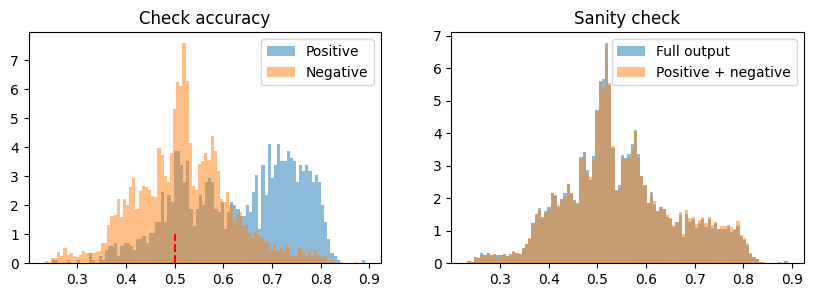

In [ ]:
## Bling test

# Model and encoding
model.eval()
g = nx.stochastic_block_model(sizes, sbm_matrix)
# g = nx.barabasi_albert_graph(N, m)
g_corrupted = corruptNetwork(g, 0.1)
edge_index_corrupted = graphToEdgelist(g_corrupted)
x = obtainFeatureMatrix(g_corrupted)
z = model.encode(x, edge_index_corrupted)

# Decoding
edges = graphToEdgelist(g)
not_edges = graphToNonEdgelist(g_corrupted)
pairs = getAllPairs(N)

out = model.decode(z, pairs).view(-1) # Decode all the pairs of nodes
out_edges = model.decode(z, edges).view(-1) # Decode all the edges
out_not_edges = model.decode(z, not_edges).view(-1) # Decode all the not edges

# Cpu and detach output
out = out.cpu().detach().numpy()
out_edges = out_edges.cpu().detach().numpy()
out_not_edges = out_not_edges.cpu().detach().numpy()

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
#plt.hist(sigmoid(out), bins=100, density=True, alpha=0.5, label="Full output")
plt.hist(sigmoid(out_edges), bins=100, density=True, alpha=0.5, label="Positive")
plt.hist(sigmoid(out_not_edges), bins=100, density=True, alpha=0.5, label="Negative")
plt.legend()
plt.vlines(0.5, 0, 1, linestyles='dashed', colors='red')
plt.title("Check accuracy")

plt.subplot(1, 2, 2)
plt.hist(sigmoid(out), bins=100, density=True, alpha=0.5, label="Full output")
plt.hist(sigmoid(np.concatenate([out_edges, out_not_edges])), bins=100, density=True, alpha=0.5, label="Positive + negative")
plt.legend()
plt.title("Sanity check");

100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


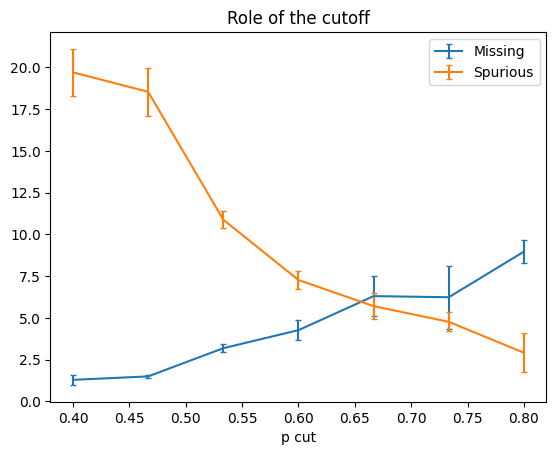

In [ ]:
p_vec = np.linspace(0.4, 0.8, 7)
trials = 5

missing_ratio = np.zeros((len(p_vec), trials))
spurious_ratio = np.zeros((len(p_vec), trials))
for i in tqdm(range(len(p_vec))):
    p = p_vec[i]
    for t in range(trials):
        missing, spurious = testNetworkReconstruction(p_cut=p)
        missing_ratio[i, t] = missing
        spurious_ratio[i, t] = spurious

plt.title("Role of the cutoff")
#plt.plot(p_vec, np.mean(missing_ratio, axis=1), label="Missing")
plt.errorbar(p_vec, np.mean(missing_ratio, axis=1), yerr=np.std(missing_ratio, axis=1), label="Missing", capsize=2)
#plt.plot(p_vec, np.mean(spurious_ratio, axis=1), label="Spurious")
plt.errorbar(p_vec, np.mean(spurious_ratio, axis=1), yerr=np.std(spurious_ratio, axis=1), label="Spurious", capsize=2)
plt.legend()
plt.xlabel("p cut");

In the figure above the ratio is for instance missing_recon / missing_obs, which means that we would like a value lower than one.

In [ ]:
# Full training (early stopping, etc...)
loss_history = []
val_history = []
bestValScore = 0
patience = 10
patienceCounter = 0
minDelta = 0.001
bestModelState = None
model = Net(9, 1028, 8)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005, weight_decay=5e-4)

for epoch in tqdm(range(1, 101)):
    loss = train()
    score = test()

    loss_history.append(loss.cpu().detach().numpy())
    val_history.append(score)

    if score > bestValScore + minDelta:
        bestValScore = score
        patienceCounter = 0
        bestModelState = model.state_dict()
    else:
        patienceCounter += 1

    if patienceCounter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

if bestModelState is not None:
    model.load_state_dict(bestModelState)
    print("Loaded best model state")

 21%|██        | 21/100 [00:11<00:43,  1.83it/s]

Early stopping at epoch 22
Loaded best model state


In [ ]:
bestModelState

OrderedDict([('conv1.bias',
              tensor([-0.0214, -0.0101, -0.0082,  ..., -0.0121,  0.0128, -0.0122])),
             ('conv1.lin.weight',
              tensor([[-0.0299,  0.0208, -0.0770,  ...,  0.0143, -0.0166, -0.0210],
                      [-0.0105, -0.0523, -0.0124,  ..., -0.0027, -0.0061, -0.0067],
                      [-0.0167, -0.0047,  0.0118,  ...,  0.0493,  0.0577,  0.0016],
                      ...,
                      [ 0.0032, -0.0038, -0.0148,  ..., -0.0635,  0.0616,  0.0367],
                      [ 0.0155,  0.0210,  0.0016,  ...,  0.0015,  0.0134,  0.0160],
                      [ 0.0516, -0.0368,  0.0590,  ...,  0.0033, -0.0263,  0.0343]])),
             ('conv2.bias',
              tensor([ 0.0014, -0.0011, -0.0008,  0.0007, -0.0003,  0.0007,  0.0005,  0.0008])),
             ('conv2.lin.weight',
              tensor([[ 0.0103,  0.0036, -0.0089,  ..., -0.0646,  0.0204,  0.0374],
                      [-0.0200, -0.0231,  0.0395,  ...,  0.0613, -0.0254,  0

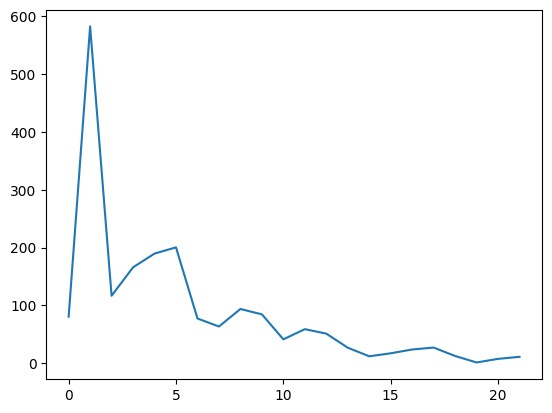

In [ ]:
plt.plot(loss_history)
plt.yscale("linear")

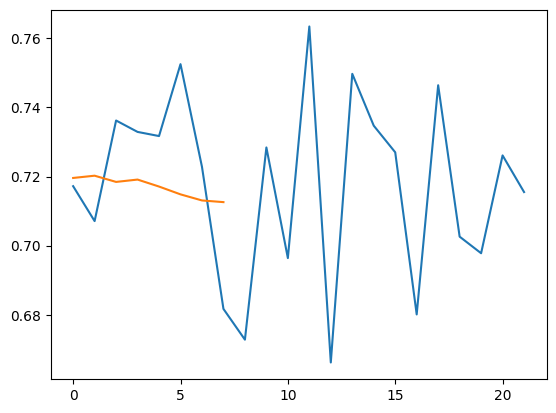

In [ ]:
plt.plot(val_history)
# Plot moving average
plt.plot(np.convolve(val_history, np.ones(15)/15, mode='valid'))

Il problema è che la validation oscilla tantissimo e non si stabilizza?
- overfitting o underfitting?
- necessità di più features per i nodi?


# COMBINATORY FOR CONFIGURATION AND LEARNING RATE

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

# Range dei tassi di apprendimento
exps = np.arange(-7, 0)
learningRates = [10.0**exp for exp in exps]

learningRates = [0.001, 0.005, 0.01, 0.05]

# Lista per memorizzare i risultati finali per ciascun tasso di apprendimento
finalValsL = []

for learningRate in learningRates:
    print("The learning rate is", learningRate)
    model = Net(9, 8, 4)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learningRate, weight_decay=5e-4)

    finalVals = []

    for iteration in range(10):  # Modifica il numero di iterazioni se necessario
        loss_history = []
        val_history = []
        bestValScore = 0
        patience = 10
        patienceCounter = 0
        minDelta = 0.01
        bestModelState = None

        for epoch in tqdm(range(1, 101)):
            loss = train()
            score = test()

            loss_history.append(loss.cpu().detach().numpy())
            val_history.append(score)

            if score > bestValScore + minDelta:
                bestValScore = score
                patienceCounter = 0
                bestModelState = model.state_dict()
            else:
                patienceCounter += 1

            if patienceCounter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if bestModelState is not None:
            model.load_state_dict(bestModelState)
        finalVals.append(val_history[-1])

    # Calcola il valore finale medio per questo tasso di apprendimento
    finalVal = np.mean(finalVals)
    finalValsL.append(finalVal)
    print("The final value of the accuracy is", finalVal)

# Trova il miglior tasso di apprendimento
bestLearningRate = learningRates[np.argmax(finalValsL)]
print("The better performances are obtained with the learning rate =", bestLearningRate)
print("The best accuracy obtained is", np.max(finalValsL))


The learning rate is 0.001


 11%|█         | 11/100 [00:06<00:55,  1.60it/s]


Early stopping at epoch 12


 14%|█▍        | 14/100 [00:06<00:42,  2.00it/s]


Early stopping at epoch 15


 21%|██        | 21/100 [00:11<00:44,  1.76it/s]


Early stopping at epoch 22


 10%|█         | 10/100 [00:05<00:53,  1.70it/s]


Early stopping at epoch 11


 14%|█▍        | 14/100 [00:07<00:44,  1.91it/s]


Early stopping at epoch 15


 10%|█         | 10/100 [00:06<01:00,  1.48it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:05<00:51,  1.75it/s]


Early stopping at epoch 11


 15%|█▌        | 15/100 [00:09<00:55,  1.54it/s]


Early stopping at epoch 16


 13%|█▎        | 13/100 [00:06<00:42,  2.05it/s]


Early stopping at epoch 14


 21%|██        | 21/100 [00:12<00:45,  1.72it/s]


Early stopping at epoch 22
The final value of the accuracy is 0.72346
The learning rate is 0.005


 16%|█▌        | 16/100 [00:11<01:02,  1.34it/s]


Early stopping at epoch 17


 19%|█▉        | 19/100 [00:12<00:53,  1.53it/s]


Early stopping at epoch 20


 12%|█▏        | 12/100 [00:06<00:44,  1.97it/s]


Early stopping at epoch 13


 10%|█         | 10/100 [00:05<00:53,  1.68it/s]


Early stopping at epoch 11


 18%|█▊        | 18/100 [00:10<00:47,  1.71it/s]


Early stopping at epoch 19


 10%|█         | 10/100 [00:04<00:44,  2.01it/s]


Early stopping at epoch 11


 20%|██        | 20/100 [00:10<00:42,  1.89it/s]


Early stopping at epoch 21


 15%|█▌        | 15/100 [00:09<00:52,  1.62it/s]


Early stopping at epoch 16


 13%|█▎        | 13/100 [00:06<00:42,  2.07it/s]


Early stopping at epoch 14


 11%|█         | 11/100 [00:06<00:52,  1.71it/s]


Early stopping at epoch 12
The final value of the accuracy is 0.7383900000000001
The learning rate is 0.01


 11%|█         | 11/100 [00:05<00:43,  2.04it/s]


Early stopping at epoch 12


 36%|███▌      | 36/100 [00:18<00:32,  1.99it/s]


Early stopping at epoch 37


 15%|█▌        | 15/100 [00:08<00:50,  1.68it/s]


Early stopping at epoch 16


 18%|█▊        | 18/100 [00:09<00:44,  1.85it/s]


Early stopping at epoch 19


 15%|█▌        | 15/100 [00:07<00:40,  2.08it/s]


Early stopping at epoch 16


 15%|█▌        | 15/100 [00:09<00:51,  1.66it/s]


Early stopping at epoch 16


 12%|█▏        | 12/100 [00:06<00:48,  1.80it/s]


Early stopping at epoch 13


 27%|██▋       | 27/100 [00:14<00:39,  1.84it/s]


Early stopping at epoch 28


 19%|█▉        | 19/100 [00:08<00:38,  2.13it/s]


Early stopping at epoch 20


 10%|█         | 10/100 [00:05<00:53,  1.67it/s]


Early stopping at epoch 11
The final value of the accuracy is 0.7345800000000001
The learning rate is 0.05


 10%|█         | 10/100 [00:04<00:44,  2.03it/s]


Early stopping at epoch 11


 14%|█▍        | 14/100 [00:07<00:47,  1.80it/s]


Early stopping at epoch 15


 10%|█         | 10/100 [00:04<00:43,  2.05it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:05<00:52,  1.72it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:05<00:48,  1.85it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:04<00:44,  2.04it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:06<00:55,  1.63it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:04<00:44,  2.04it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:05<00:53,  1.68it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:04<00:43,  2.08it/s]

Early stopping at epoch 11
The final value of the accuracy is 0.50587
The better performances are obtained with the learning rate = 0.005
The best accuracy obtained is 0.7383900000000001


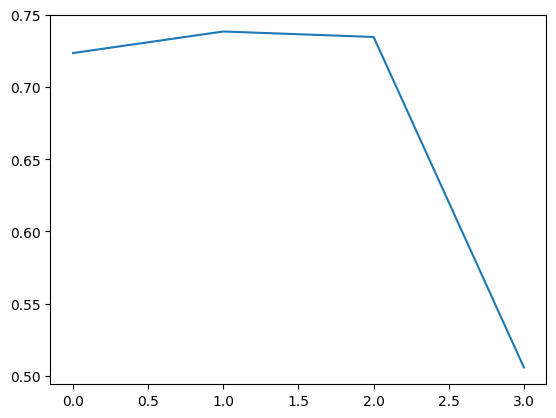

In [ ]:
plt.plot(finalValsL)

In [ ]:
configuration = [
    (9, 4, 2),
    (9, 8, 2),
    (9, 16, 2),
    (9, 32, 2),
    (9, 64, 2),
    (9, 128, 2),
    (9, 256, 2),
    (9, 4, 4),
    (9, 8, 4),
    (9, 16, 4),
    (9, 32, 4),
    (9, 64, 4),
    (9, 128, 4),
    (9, 256, 4),
    (9, 8, 8),
    (9, 16, 8),
    (9, 32, 8),
    (9, 64, 8),
    (9, 128, 8),
    (9, 256, 8),

]
means = []
for i in configuration:
    print("The configuration of the model is",i)
    model = Net(*i)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=bestLearningRate, weight_decay=5e-4)


    for iteration in range(10):

        finalVal = []
        loss_history = []
        val_history = []
        bestValScore = 0
        patience = 10
        patienceCounter = 0
        minDelta = 0.01
        bestModelState = None

        for epoch in tqdm(range(1, 101)):
            loss = train()
            score = test()

            loss_history.append(loss.cpu().detach().numpy())
            val_history.append(score)
            # print(f"Epoch {epoch}: Loss = {loss.item()}, Score = {score}")

            if score > bestValScore + minDelta:
                bestValScore = score
                patienceCounter = 0
                bestModelState = model.state_dict()
            else:
                patienceCounter += 1

            if patienceCounter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if bestModelState is not None:
            model.load_state_dict(bestModelState)
        finalVal.append(val_history[-1])
    finalMeans = np.mean(finalVal)
    print("The final value of the accuracy is", np.mean(finalVal))
    means.append(finalMeans)

bestConfiguration = configuration[np.argmax(means)]
print("The better performances are obtained with the configuration = ", bestConfiguration)
print("The better accuracy obtained is", np.max(means))

The configuration of the model is (9, 4, 2)


 24%|██▍       | 24/100 [00:12<00:38,  1.98it/s]


Early stopping at epoch 25


 13%|█▎        | 13/100 [00:06<00:43,  2.01it/s]


Early stopping at epoch 14


 17%|█▋        | 17/100 [00:10<00:50,  1.66it/s]


Early stopping at epoch 18


 13%|█▎        | 13/100 [00:07<00:50,  1.71it/s]


Early stopping at epoch 14


 16%|█▌        | 16/100 [00:07<00:39,  2.10it/s]


Early stopping at epoch 17


 28%|██▊       | 28/100 [00:15<00:39,  1.83it/s]


Early stopping at epoch 29


 12%|█▏        | 12/100 [00:06<00:47,  1.84it/s]


Early stopping at epoch 13


 12%|█▏        | 12/100 [00:06<00:47,  1.86it/s]


Early stopping at epoch 13


 13%|█▎        | 13/100 [00:07<00:49,  1.74it/s]


Early stopping at epoch 14


 27%|██▋       | 27/100 [00:14<00:39,  1.84it/s]


Early stopping at epoch 28
The final value of the accuracy is 0.7263
The configuration of the model is (9, 8, 2)


 19%|█▉        | 19/100 [00:10<00:44,  1.83it/s]


Early stopping at epoch 20


 23%|██▎       | 23/100 [00:12<00:41,  1.87it/s]


Early stopping at epoch 24


 14%|█▍        | 14/100 [00:06<00:42,  2.01it/s]


Early stopping at epoch 15


 12%|█▏        | 12/100 [00:07<00:52,  1.68it/s]


Early stopping at epoch 13


 10%|█         | 10/100 [00:05<00:45,  1.97it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:06<00:59,  1.52it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:05<00:47,  1.90it/s]


Early stopping at epoch 11


 17%|█▋        | 17/100 [00:09<00:46,  1.78it/s]


Early stopping at epoch 18


 10%|█         | 10/100 [00:05<00:45,  2.00it/s]


Early stopping at epoch 11


 14%|█▍        | 14/100 [00:08<00:49,  1.73it/s]


Early stopping at epoch 15
The final value of the accuracy is 0.7305999999999999
The configuration of the model is (9, 16, 2)


 16%|█▌        | 16/100 [00:08<00:46,  1.81it/s]


Early stopping at epoch 17


 13%|█▎        | 13/100 [00:06<00:43,  2.00it/s]


Early stopping at epoch 14


 23%|██▎       | 23/100 [00:12<00:40,  1.89it/s]


Early stopping at epoch 24


 10%|█         | 10/100 [00:05<00:49,  1.81it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:06<00:54,  1.64it/s]


Early stopping at epoch 11


 14%|█▍        | 14/100 [00:08<00:54,  1.58it/s]


Early stopping at epoch 15


 12%|█▏        | 12/100 [00:06<00:46,  1.88it/s]


Early stopping at epoch 13


 18%|█▊        | 18/100 [00:10<00:45,  1.79it/s]


Early stopping at epoch 19


 10%|█         | 10/100 [00:05<00:45,  1.97it/s]


Early stopping at epoch 11


 28%|██▊       | 28/100 [00:14<00:38,  1.87it/s]


Early stopping at epoch 29
The final value of the accuracy is 0.7726000000000001
The configuration of the model is (9, 32, 2)


 10%|█         | 10/100 [00:06<01:02,  1.45it/s]


Early stopping at epoch 11


 19%|█▉        | 19/100 [00:11<00:46,  1.72it/s]


Early stopping at epoch 20


 10%|█         | 10/100 [00:05<00:50,  1.77it/s]


Early stopping at epoch 11


 25%|██▌       | 25/100 [00:14<00:42,  1.78it/s]


Early stopping at epoch 26


 22%|██▏       | 22/100 [00:12<00:44,  1.77it/s]


Early stopping at epoch 23


 13%|█▎        | 13/100 [00:07<00:48,  1.79it/s]


Early stopping at epoch 14


 12%|█▏        | 12/100 [00:06<00:50,  1.73it/s]


Early stopping at epoch 13


 11%|█         | 11/100 [00:06<00:53,  1.68it/s]


Early stopping at epoch 12


 10%|█         | 10/100 [00:06<00:54,  1.66it/s]


Early stopping at epoch 11


 12%|█▏        | 12/100 [00:06<00:46,  1.91it/s]


Early stopping at epoch 13
The final value of the accuracy is 0.5267000000000001
The configuration of the model is (9, 64, 2)


 13%|█▎        | 13/100 [00:07<00:52,  1.66it/s]


Early stopping at epoch 14


 20%|██        | 20/100 [00:11<00:44,  1.78it/s]


Early stopping at epoch 21


 11%|█         | 11/100 [00:05<00:46,  1.93it/s]


Early stopping at epoch 12


 13%|█▎        | 13/100 [00:08<00:53,  1.62it/s]


Early stopping at epoch 14


 13%|█▎        | 13/100 [00:06<00:44,  1.95it/s]


Early stopping at epoch 14


 10%|█         | 10/100 [00:06<01:00,  1.50it/s]


Early stopping at epoch 11


 19%|█▉        | 19/100 [00:10<00:45,  1.80it/s]


Early stopping at epoch 20


 22%|██▏       | 22/100 [00:12<00:42,  1.83it/s]


Early stopping at epoch 23


 10%|█         | 10/100 [00:06<01:02,  1.43it/s]


Early stopping at epoch 11


 11%|█         | 11/100 [00:05<00:45,  1.95it/s]


Early stopping at epoch 12
The final value of the accuracy is 0.7984000000000001
The configuration of the model is (9, 128, 2)


 19%|█▉        | 19/100 [00:10<00:45,  1.77it/s]


Early stopping at epoch 20


 16%|█▌        | 16/100 [00:09<00:48,  1.73it/s]


Early stopping at epoch 17


 14%|█▍        | 14/100 [00:07<00:45,  1.88it/s]


Early stopping at epoch 15


 16%|█▌        | 16/100 [00:09<00:49,  1.71it/s]


Early stopping at epoch 17


 12%|█▏        | 12/100 [00:06<00:49,  1.79it/s]


Early stopping at epoch 13


 11%|█         | 11/100 [00:06<00:53,  1.67it/s]


Early stopping at epoch 12


 16%|█▌        | 16/100 [00:09<00:49,  1.69it/s]


Early stopping at epoch 17


 10%|█         | 10/100 [00:05<00:46,  1.92it/s]


Early stopping at epoch 11


 14%|█▍        | 14/100 [00:08<00:52,  1.65it/s]


Early stopping at epoch 15


 24%|██▍       | 24/100 [00:13<00:43,  1.74it/s]


Early stopping at epoch 25
The final value of the accuracy is 0.7340000000000001
The configuration of the model is (9, 256, 2)


 24%|██▍       | 24/100 [00:13<00:42,  1.81it/s]


Early stopping at epoch 25


 37%|███▋      | 37/100 [00:19<00:33,  1.89it/s]


Early stopping at epoch 38


 13%|█▎        | 13/100 [00:08<00:54,  1.61it/s]


Early stopping at epoch 14


 16%|█▌        | 16/100 [00:08<00:43,  1.95it/s]


Early stopping at epoch 17


 14%|█▍        | 14/100 [00:08<00:53,  1.61it/s]


Early stopping at epoch 15


 11%|█         | 11/100 [00:06<00:49,  1.81it/s]


Early stopping at epoch 12


 22%|██▏       | 22/100 [00:12<00:43,  1.81it/s]


Early stopping at epoch 23


 16%|█▌        | 16/100 [00:09<00:49,  1.68it/s]


Early stopping at epoch 17


 16%|█▌        | 16/100 [00:10<00:54,  1.54it/s]


Early stopping at epoch 17


 11%|█         | 11/100 [00:06<00:49,  1.78it/s]


Early stopping at epoch 12
The final value of the accuracy is 0.7788
The configuration of the model is (9, 4, 4)


 18%|█▊        | 18/100 [00:10<00:47,  1.74it/s]


Early stopping at epoch 19


 10%|█         | 10/100 [00:05<00:46,  1.92it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:06<01:00,  1.48it/s]


Early stopping at epoch 11


 16%|█▌        | 16/100 [00:08<00:44,  1.89it/s]


Early stopping at epoch 17


 30%|███       | 30/100 [00:16<00:39,  1.77it/s]


Early stopping at epoch 31


 17%|█▋        | 17/100 [00:08<00:40,  2.03it/s]


Early stopping at epoch 18


 16%|█▌        | 16/100 [00:08<00:45,  1.84it/s]


Early stopping at epoch 17


 21%|██        | 21/100 [00:11<00:42,  1.87it/s]


Early stopping at epoch 22


 28%|██▊       | 28/100 [00:14<00:36,  1.98it/s]


Early stopping at epoch 29


 10%|█         | 10/100 [00:04<00:43,  2.05it/s]


Early stopping at epoch 11
The final value of the accuracy is 0.7287999999999999
The configuration of the model is (9, 8, 4)


 10%|█         | 10/100 [00:06<00:55,  1.63it/s]


Early stopping at epoch 11


 11%|█         | 11/100 [00:05<00:42,  2.07it/s]


Early stopping at epoch 12


 20%|██        | 20/100 [00:10<00:42,  1.89it/s]


Early stopping at epoch 21


 11%|█         | 11/100 [00:05<00:43,  2.05it/s]


Early stopping at epoch 12


 17%|█▋        | 17/100 [00:09<00:46,  1.77it/s]


Early stopping at epoch 18


 16%|█▌        | 16/100 [00:08<00:46,  1.80it/s]


Early stopping at epoch 17


 12%|█▏        | 12/100 [00:05<00:42,  2.06it/s]


Early stopping at epoch 13


 19%|█▉        | 19/100 [00:10<00:43,  1.86it/s]


Early stopping at epoch 20


 12%|█▏        | 12/100 [00:06<00:44,  1.99it/s]


Early stopping at epoch 13


 10%|█         | 10/100 [00:05<00:53,  1.69it/s]


Early stopping at epoch 11
The final value of the accuracy is 0.6419
The configuration of the model is (9, 16, 4)


 11%|█         | 11/100 [00:05<00:43,  2.03it/s]


Early stopping at epoch 12


 10%|█         | 10/100 [00:06<00:54,  1.65it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:05<00:45,  1.96it/s]


Early stopping at epoch 11


 15%|█▌        | 15/100 [00:09<00:52,  1.62it/s]


Early stopping at epoch 16


 12%|█▏        | 12/100 [00:05<00:43,  2.04it/s]


Early stopping at epoch 13


 21%|██        | 21/100 [00:10<00:40,  1.93it/s]


Early stopping at epoch 22


 11%|█         | 11/100 [00:06<00:52,  1.71it/s]


Early stopping at epoch 12


 11%|█         | 11/100 [00:05<00:43,  2.06it/s]


Early stopping at epoch 12


 20%|██        | 20/100 [00:10<00:41,  1.93it/s]


Early stopping at epoch 21


 18%|█▊        | 18/100 [00:09<00:43,  1.89it/s]


Early stopping at epoch 19
The final value of the accuracy is 0.8128000000000001
The configuration of the model is (9, 32, 4)


 19%|█▉        | 19/100 [00:08<00:38,  2.12it/s]


Early stopping at epoch 20


 10%|█         | 10/100 [00:05<00:53,  1.69it/s]


Early stopping at epoch 11


 29%|██▉       | 29/100 [00:14<00:35,  2.01it/s]


Early stopping at epoch 30


 13%|█▎        | 13/100 [00:06<00:41,  2.09it/s]


Early stopping at epoch 14


 11%|█         | 11/100 [00:06<00:50,  1.76it/s]


Early stopping at epoch 12


 11%|█         | 11/100 [00:05<00:43,  2.06it/s]


Early stopping at epoch 12


 12%|█▏        | 12/100 [00:07<00:51,  1.69it/s]


Early stopping at epoch 13


 16%|█▌        | 16/100 [00:08<00:42,  1.97it/s]


Early stopping at epoch 17


 12%|█▏        | 12/100 [00:06<00:46,  1.89it/s]


Early stopping at epoch 13


 34%|███▍      | 34/100 [00:16<00:32,  2.02it/s]


Early stopping at epoch 35
The final value of the accuracy is 0.7008000000000001
The configuration of the model is (9, 64, 4)


 15%|█▌        | 15/100 [00:08<00:46,  1.82it/s]


Early stopping at epoch 16


 29%|██▉       | 29/100 [00:14<00:35,  1.99it/s]


Early stopping at epoch 30


 11%|█         | 11/100 [00:06<00:55,  1.61it/s]


Early stopping at epoch 12


 10%|█         | 10/100 [00:05<00:47,  1.90it/s]


Early stopping at epoch 11


 23%|██▎       | 23/100 [00:12<00:40,  1.88it/s]


Early stopping at epoch 24


 23%|██▎       | 23/100 [00:13<00:44,  1.72it/s]


Early stopping at epoch 24


 13%|█▎        | 13/100 [00:06<00:43,  2.00it/s]


Early stopping at epoch 14


 18%|█▊        | 18/100 [00:09<00:44,  1.82it/s]


Early stopping at epoch 19


 10%|█         | 10/100 [00:06<00:56,  1.60it/s]


Early stopping at epoch 11


 16%|█▌        | 16/100 [00:08<00:43,  1.95it/s]


Early stopping at epoch 17
The final value of the accuracy is 0.7293000000000001
The configuration of the model is (9, 128, 4)


 14%|█▍        | 14/100 [00:08<00:49,  1.73it/s]


Early stopping at epoch 15


 11%|█         | 11/100 [00:05<00:45,  1.98it/s]


Early stopping at epoch 12


 22%|██▏       | 22/100 [00:11<00:41,  1.89it/s]


Early stopping at epoch 23


 12%|█▏        | 12/100 [00:07<00:51,  1.70it/s]


Early stopping at epoch 13


 20%|██        | 20/100 [00:09<00:38,  2.09it/s]


Early stopping at epoch 21


 11%|█         | 11/100 [00:06<00:53,  1.66it/s]


Early stopping at epoch 12


 14%|█▍        | 14/100 [00:07<00:44,  1.95it/s]


Early stopping at epoch 15


 13%|█▎        | 13/100 [00:06<00:46,  1.87it/s]


Early stopping at epoch 14


 12%|█▏        | 12/100 [00:06<00:48,  1.81it/s]


Early stopping at epoch 13


 13%|█▎        | 13/100 [00:06<00:45,  1.93it/s]


Early stopping at epoch 14
The final value of the accuracy is 0.8197
The configuration of the model is (9, 256, 4)


 12%|█▏        | 12/100 [00:06<00:50,  1.73it/s]


Early stopping at epoch 13


 13%|█▎        | 13/100 [00:06<00:43,  2.00it/s]


Early stopping at epoch 14


 10%|█         | 10/100 [00:05<00:50,  1.78it/s]


Early stopping at epoch 11


 11%|█         | 11/100 [00:05<00:46,  1.90it/s]


Early stopping at epoch 12


 15%|█▌        | 15/100 [00:08<00:47,  1.77it/s]


Early stopping at epoch 16


 14%|█▍        | 14/100 [00:06<00:41,  2.08it/s]


Early stopping at epoch 15


 16%|█▌        | 16/100 [00:08<00:45,  1.86it/s]


Early stopping at epoch 17


 22%|██▏       | 22/100 [00:11<00:40,  1.92it/s]


Early stopping at epoch 23


 10%|█         | 10/100 [00:04<00:44,  2.01it/s]


Early stopping at epoch 11


 16%|█▌        | 16/100 [00:08<00:46,  1.82it/s]


Early stopping at epoch 17
The final value of the accuracy is 0.7382000000000001
The configuration of the model is (9, 8, 8)


 26%|██▌       | 26/100 [00:14<00:41,  1.79it/s]


Early stopping at epoch 27


 17%|█▋        | 17/100 [00:08<00:41,  2.00it/s]


Early stopping at epoch 18


 10%|█         | 10/100 [00:05<00:50,  1.79it/s]


Early stopping at epoch 11


 13%|█▎        | 13/100 [00:06<00:41,  2.09it/s]


Early stopping at epoch 14


 10%|█         | 10/100 [00:06<00:55,  1.63it/s]


Early stopping at epoch 11


 15%|█▌        | 15/100 [00:07<00:41,  2.06it/s]


Early stopping at epoch 16


 16%|█▌        | 16/100 [00:08<00:44,  1.89it/s]


Early stopping at epoch 17


 18%|█▊        | 18/100 [00:09<00:43,  1.89it/s]


Early stopping at epoch 19


 15%|█▌        | 15/100 [00:07<00:41,  2.04it/s]


Early stopping at epoch 16


 21%|██        | 21/100 [00:10<00:40,  1.94it/s]


Early stopping at epoch 22
The final value of the accuracy is 0.7757999999999999
The configuration of the model is (9, 16, 8)


 12%|█▏        | 12/100 [00:06<00:50,  1.76it/s]


Early stopping at epoch 13


 12%|█▏        | 12/100 [00:05<00:41,  2.10it/s]


Early stopping at epoch 13


 11%|█         | 11/100 [00:06<00:50,  1.76it/s]


Early stopping at epoch 12


 11%|█         | 11/100 [00:05<00:42,  2.08it/s]


Early stopping at epoch 12


 10%|█         | 10/100 [00:05<00:47,  1.90it/s]


Early stopping at epoch 11


 11%|█         | 11/100 [00:06<00:48,  1.83it/s]


Early stopping at epoch 12


 11%|█         | 11/100 [00:05<00:45,  1.96it/s]


Early stopping at epoch 12


 11%|█         | 11/100 [00:06<00:52,  1.70it/s]


Early stopping at epoch 12


 15%|█▌        | 15/100 [00:07<00:42,  2.00it/s]


Early stopping at epoch 16


 11%|█         | 11/100 [00:06<00:48,  1.82it/s]


Early stopping at epoch 12
The final value of the accuracy is 0.7381
The configuration of the model is (9, 32, 8)


 14%|█▍        | 14/100 [00:07<00:44,  1.93it/s]


Early stopping at epoch 15


 16%|█▌        | 16/100 [00:08<00:42,  1.98it/s]


Early stopping at epoch 17


 20%|██        | 20/100 [00:10<00:41,  1.93it/s]


Early stopping at epoch 21


 17%|█▋        | 17/100 [00:09<00:45,  1.81it/s]


Early stopping at epoch 18


 11%|█         | 11/100 [00:05<00:43,  2.06it/s]


Early stopping at epoch 12


 17%|█▋        | 17/100 [00:08<00:43,  1.90it/s]


Early stopping at epoch 18


 16%|█▌        | 16/100 [00:07<00:39,  2.13it/s]


Early stopping at epoch 17


 23%|██▎       | 23/100 [00:12<00:42,  1.82it/s]


Early stopping at epoch 24


 15%|█▌        | 15/100 [00:08<00:46,  1.83it/s]


Early stopping at epoch 16


 12%|█▏        | 12/100 [00:06<00:45,  1.94it/s]


Early stopping at epoch 13
The final value of the accuracy is 0.7733
The configuration of the model is (9, 64, 8)


 13%|█▎        | 13/100 [00:07<00:47,  1.82it/s]


Early stopping at epoch 14


 12%|█▏        | 12/100 [00:06<00:47,  1.84it/s]


Early stopping at epoch 13


 15%|█▌        | 15/100 [00:07<00:43,  1.97it/s]


Early stopping at epoch 16


 14%|█▍        | 14/100 [00:07<00:47,  1.82it/s]


Early stopping at epoch 15


 11%|█         | 11/100 [00:05<00:43,  2.06it/s]


Early stopping at epoch 12


 19%|█▉        | 19/100 [00:09<00:42,  1.91it/s]


Early stopping at epoch 20


 10%|█         | 10/100 [00:04<00:43,  2.05it/s]


Early stopping at epoch 11


 10%|█         | 10/100 [00:06<00:54,  1.66it/s]


Early stopping at epoch 11


 12%|█▏        | 12/100 [00:06<00:44,  1.96it/s]


Early stopping at epoch 13


 18%|█▊        | 18/100 [00:09<00:44,  1.85it/s]


Early stopping at epoch 19
The final value of the accuracy is 0.8171
The configuration of the model is (9, 128, 8)


 12%|█▏        | 12/100 [00:05<00:44,  1.98it/s]

In [ ]:
means

## Training

In [10]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

dataset = Planetoid("./data/", name='PubMed', transform=transform)

# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.

train_data, val_data, test_data = dataset[0]

In [11]:
print(dir(dataset))

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_data', '_data_list', '_download', '_indices', '_infer_num_classes', '_is_protocol', '_process', 'collate', 'copy', 'cpu', 'cuda', 'data', 'download', 'force_reload', 'geom_gcn_url', 'get', 'get_summary', 'has_download', 'has_process', 'index_select', 'indices', 'len', 'load', 'log', 'name', 'num_classes', 'num_edge_features', 'num_features', 'num_node_features', 'pre_filter', 'pre_transform', 'print_summary', 'process', 'processed_dir', 'processed_file_names', 'processed_paths', 'raw_dir', 'raw_

In [12]:
print(dataset)
print("number of graphs:\t\t",len(dataset)) # A dataset is a collection of graphs (one in this case)
print("number of classes:\t\t",dataset.num_classes) # Node labels for node classification
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

PubMed()
number of graphs:		 1
number of classes:		 3
number of node features:	 500
number of edge features:	 0


In [13]:
print("edge_index:\t\t",dataset.data.edge_index.shape) # edge list, shape (2, #edges)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape) # node feature matrix, shape (#nodes, #feature)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape) # node labels, shape (#nodes)
print(dataset.data.y)

edge_index:		 torch.Size([2, 88648])
tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])


train_mask:		 torch.Size([19717])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([19717, 500])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


y:		 torch.Size([19717])
tensor([1, 1, 0,  ..., 2, 0, 2])


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [14]:
print(train_data.keys())

['test_mask', 'edge_index', 'val_mask', 'edge_label_index', 'x', 'y', 'edge_label', 'train_mask']


In [15]:
test_data.edge_label_index.shape

torch.Size([2, 8864])

In [16]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        ## Check cached option for transductive learning
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        z = self.conv2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [17]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

train_data.edge_label_index is the first half of the train_data.edge_index tensor (!)

In [40]:
compareEdgeLists(val_data.edge_label_index, test_data.edge_label_index)

(4432, 8864)

In [83]:
def train():
    model.train()
    optimizer.zero_grad()

    # Encoding
    # This is where the message passing happens within the GNN model
    #x = torch.eye(100, dtype=torch.float, device=device)

    z = model.encode(train_data.x, train_data.edge_index)
    #print(f"train_data.edge_index.shape = {train_data.edge_index.shape}")
    #print(f"z.shape = {z.shape}")

    """ We perform a new round of negative sampling for every training epoch """
    # Negative sampling: read https://datafireball.com/2023/07/15/torch_geometric-negative-sampling/
    # neg_edge_index has shape (2, #training_edges/2)
    # How does it work? Does it sample from the pairs of nodes that **probably** are not edges? (Yes)
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    #print(f"neg_edge_index.shape = {neg_edge_index.shape}")
    #print(f"train_data.edge_label_index.shape = {train_data.edge_label_index.shape}")

    # Edge label index = Positive Examples (fixed?) U Negative Examples (sampled)
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    #print(f"edge_label_index.shape = {edge_label_index.shape}")
    #print(edge_label_index)

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)
    print(f"edge_label.shape = {edge_label.shape}")

    # Decoding
    out = model.decode(z, edge_label_index).view(-1)
    #print(out)
    #print(edge_label)
    #print(f"out.shape = {out.shape}")

    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    return loss

In [84]:
train()

z.shape = torch.Size([19717, 64])
edge_label.shape = torch.Size([75352])


tensor(0.4472, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [43]:
def train():
    model.train()
    optimizer.zero_grad()

    # Encoding
    z = model.encode(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

    # Shuffling
    shuffle = torch.randperm(edge_label_index.size(1))
    edge_label_index = edge_label_index[:, shuffle]
    edge_label = edge_label[shuffle]

    # Decoding
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    return loss


In [26]:
loss = train()
print(loss)

tensor(0.4555, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [27]:
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
@torch.no_grad()
def test(data):
    model.eval()
    # test edge_index used to encode
    #x = torch.eye(100, dtype=torch.float, device=device)
    z = model.encode(data.x, data.edge_index)

    # test edge_label_index are not in the edge_index list
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    # Evaluate score
    out_cpu = out.cpu().numpy()
    label_cpu = data.edge_label.cpu().numpy()
    # Shuffle
    shuffle = torch.randperm(out_cpu.shape[0])
    out_cpu = out_cpu[shuffle]
    label_cpu = label_cpu[shuffle]
    auc = roc_auc_score(label_cpu, out_cpu)
    return auc

In [ ]:
@torch.no_grad()
def testOP(data):
    model.eval()
    # test edge_index used to encode
    z = model.encode(data.x, data.edge_index)

    # test edge_label_index are not in the edge_index list
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    # Evaluate score
    out_cpu = out.cpu().numpy()
    label_cpu = data.edge_label.cpu().numpy()
    # Shuffle
    shuffle = torch.randperm(out_cpu.shape[0])
    out_cpu = out_cpu[shuffle]
    label_cpu = label_cpu[shuffle]
    auc = roc_auc_score(label_cpu, out_cpu)
    return out_cpu, label_cpu, auc

AUC = 0.9220427106999989


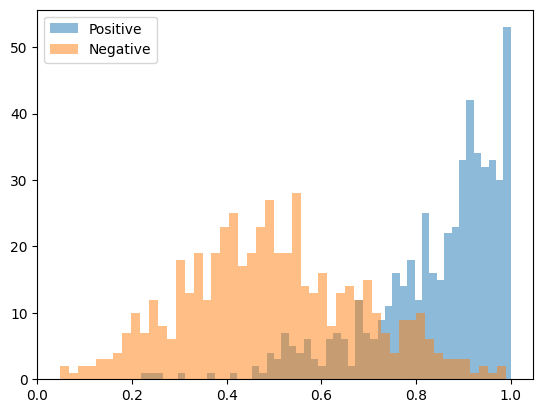

In [ ]:
out_cpu, label_cpu, auc = testOP(test_data)
plt.hist(out_cpu[label_cpu == 1], bins=50, label='Positive', alpha=0.5)
plt.hist(out_cpu[label_cpu == 0], bins=50, label='Negative', alpha=0.5)
plt.legend()
print(f"AUC = {auc}")

In [20]:
print(f"test_data.edge_index.shape = {test_data.edge_index.shape}")
test_data.edge_index

test_data.edge_index.shape = torch.Size([2, 79784])


tensor([[ 4746,  6705,   422,  ...,  9047, 11372, 12326],
        [ 5819, 17601,  3747,  ...,  5809,  5029,   370]], device='cuda:0')

In [ ]:
pair = torch.tensor([402, 1408])
torch.sum((test_data.edge_index.cpu() == pair.view(2, 1)).all(dim=0))

tensor(0)

In [ ]:
test_data.edge_label_index

tensor([[1090, 1111,  513,  ...,  402, 1958, 1408],
        [2367, 1119,  657,  ...,  337,  569,    8]], device='cuda:0')

In [ ]:
# Problem: even the test data has [1, 1, 1, ..., 0, 0, 0]
test_data.edge_label

tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')

In [45]:
val_history = []
test_history = []
loss_history = []

best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()

    val_auc = test(val_data)
    test_auc = test(test_data)

    val_history.append(val_auc)
    test_history.append(test_auc)
    loss_history.append(loss.cpu().detach().numpy())

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6928, Val: 0.8824, Test: 0.8886
Epoch: 002, Loss: 0.6675, Val: 0.8806, Test: 0.8870
Epoch: 003, Loss: 0.6943, Val: 0.8866, Test: 0.8914
Epoch: 004, Loss: 0.6541, Val: 0.8882, Test: 0.8905
Epoch: 005, Loss: 0.6647, Val: 0.8788, Test: 0.8790
Epoch: 006, Loss: 0.6688, Val: 0.8669, Test: 0.8658
Epoch: 007, Loss: 0.6652, Val: 0.8603, Test: 0.8588
Epoch: 008, Loss: 0.6542, Val: 0.8596, Test: 0.8583
Epoch: 009, Loss: 0.6391, Val: 0.8601, Test: 0.8590
Epoch: 010, Loss: 0.6356, Val: 0.8561, Test: 0.8546
Epoch: 011, Loss: 0.6439, Val: 0.8450, Test: 0.8419
Epoch: 012, Loss: 0.6336, Val: 0.8286, Test: 0.8231
Epoch: 013, Loss: 0.6238, Val: 0.8159, Test: 0.8082
Epoch: 014, Loss: 0.6246, Val: 0.8204, Test: 0.8128
Epoch: 015, Loss: 0.6250, Val: 0.8334, Test: 0.8264
Epoch: 016, Loss: 0.6217, Val: 0.8425, Test: 0.8354
Epoch: 017, Loss: 0.6142, Val: 0.8495, Test: 0.8423
Epoch: 018, Loss: 0.6069, Val: 0.8596, Test: 0.8524
Epoch: 019, Loss: 0.6026, Val: 0.8769, Test: 0.8706
Epoch: 020, 

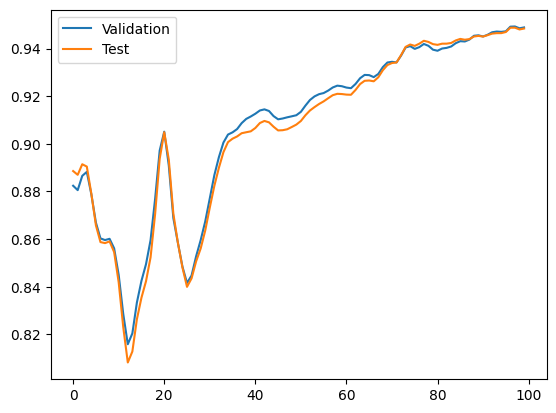

In [46]:
plt.plot(val_history, label='Validation')
plt.plot(test_history, label='Test')
plt.legend()

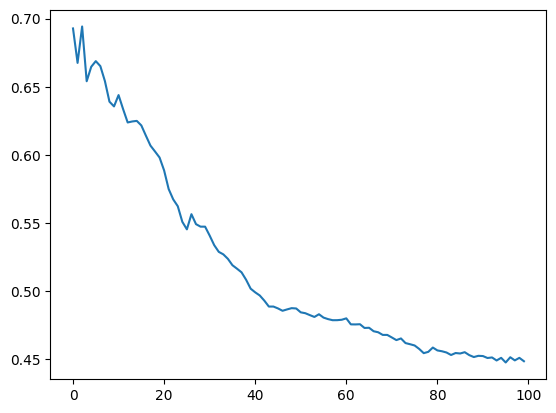

In [47]:
plt.plot(loss_history)

## Create a custom Data

In [64]:
import os.path as osp
import torch
from torch_geometric.data import Dataset, Data

g = nx.barabasi_albert_graph(100, 3)
dataset = CustomGraphDataset("./data/Custom", *customGraphData(g))

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                     add_negative_train_samples=False),
])

# Apply transformations
dataset.transform = transform
train_data, val_data, test_data = dataset[0]

# Now the training should be compatible